##### The latest version of this Jupyter notebook is available at [http://github.com/jckantor/CBE40455](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Discrete Event Simulation of a Batch Process

The simulation of batch processes as discrete event systems has a history in chemical engineering.  Special purpose software tools, including GPSS, Simula, and SLAM, have used to investigate the performance and design of batch processes since the 1960's.

Here we consider a simple example of a batch chemical process as described by [Schultheisz and Sommerfeld (1988)](http://ufdc.ufl.edu/AA00000383/00098/44).

![](../img/DES_Batch_Process.png)

The plant produces a single a product in reponse to customer orders. Customer orders arrive at random intervals uniformily distributed over a period of 115 +/- 30 minutes. The orders are held in a queue until one of three identical batch reactors can be assigned. The batch reaction time is 335 +/- 60 minutes. After completion, the batch is held in the reactor until an intermediate storage tank is available to take the batch.  The batch is feed from the storage tank to a batch distillation unit which takes 110 +/- 25 minutes to finish the product. The storage tank can hold one batch, and must be completely emptied before it is avaiable for the next batch.

The purpose of the simulation is to determine the performance of the batch plant, and to do what-if studies to explore ways to improve process performance. Typical questions include:

* What is the average length of time an order waits in the reactor queue, and is that length statistically stationary or is it growing in time?
* What is average time from arrival of an order to customer fullfillment?
* How long are the reactors held up by waiting for the availability of the storage tank?
* Would performance be improved by adding additional reactor(s)? An additional storage tank?  An additional still?
* How much will performance deteriorate if we add a clean out step before returning each reactor or the storage tank for reuse?
* What is the impact of occasional failures in the batch reactor equipment?

## Model Development in SimPy

[SimPy](https://bitbucket.org/simpy/simpy/) is a framework developed in Python using concepts from Simula and Simscript for the simulation of discrete-event systems. SimPy relies on Python's `yield` statement to [create generators](https://pythontips.com/2013/09/29/the-python-yield-keyword-explained/) that mimic event driven dynamics of the systems being simulated.

The first step in model development with SimPy is to import the appropriate development libraries. With SimPy is often useful to include the `random` library for developing stochastic applications.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import random
import itertools
import simpy

The first step in any SimPy simulation is to setup the simulation environment and define any shared resources that may be used in the course of the simulation.

In [2]:
env = simpy.Environment()

In this application, the batch process is conceptually modeled as a sequence of components that process individual orders. Here we use the SimPy [Store](http://simpy.readthedocs.io/en/latest/api_reference/simpy.resources.html) primative to describe the reactor queue and storage tank. These components will accept orders corresponding to batches, and process them on a first-in, first-out (FIFO) basis.  We'll put no upper limit on the orders that can be stored in the reactor queue, but we will establish the storage tank so that it can accept only one batch at a time.

In [3]:
N_STORAGE_TANKS = 1

reactor_queue = simpy.Store(env)
storage_tank = simpy.Store(env,N_STORAGE_TANKS)

Next we turn to the process that will generate the customer orders. The function `order_generator` begins by initializing a counter that will be used to assigned a consecutive order numbers, after which `order_generator` enters a loop that will create a total of 100 orders for the simulation.

At the start of each loop, `order_generator` issues a yield statement that will return control back to the simulation for a simulated period extending into the future. The period is given by a random number uniformly distributed in the range 115 +/- 30 minutes. 

Technically speaking, the `yield` statement defines the function as a generator of events, and provides the means for `order_generator` to communicate with other processes and to be controlled by the simulation environment. At least one `yield` statement is needed in every function that will simulate a SimPy process.

Once control returns to `order_generator`, the order counter is incremented and a second yield used to request the simuation environment put the order into the reactor queue. On return the order_generator completes the loop by writing an entry into the simulation log.

The `env.process()` creates order generator within the simulation environment. The actual simulation, however, happens later when we use `env.run()` after creating the other needed processes for this application. 

In [4]:
def order_generator(env,reactor_queue):
    orderID = 0
    while orderID < 100:
        yield env.timeout(random.uniform(115-30,115+30))
        orderID += 1
        yield reactor_queue.put(orderID)
        writeLog(env, orderID, 'Stage 0', 'Queue')
        
env.process(order_generator(env,reactor_queue))

<Process(order_generator) object at 0x10f441f28>

The user is responsible for managing the logging of simulation events.  A simple but useful approach is to initialize a Python list, then append data containing a description of the event and time at which it occurred. Later we'll see how to process this log to get the desired process performance indicators.

In [5]:
log = []
def writeLog(env, orderID, stage, event):
    log.append([orderID, stage, event, env.now])

Next we create a function `batch_reactor` that will be use to create processes corresponding to each of the three batch reactors. Each reactor is assigned a unique name so they can be distinguished in the simulation log.

The batch reactors have three interactions with the simulation environment. The first is to get an orderID from the reactor_queue. The batch_reactor yields to the simulation environment until an order is ready for processing. Once the processing can start, and suitable event is written to the log, the process waits a period of time corresponding the length of the reaction, and the order put into the storage_tank.  The reactor will wait until the storage tank is ready to accept a new batch.

`env.process()` is called three times to put three copies of the batch_reactor process into the simulation environment.

In [6]:
def batch_reactor(name, env, reactor_queue, storage_tank):
    while True:
        orderID = yield reactor_queue.get()
        writeLog(env, orderID, 'Stage 1', name)
        yield env.timeout(random.uniform(335-60,335+60))
        writeLog(env, orderID, 'Stage 2', name)
        yield storage_tank.put(orderID)
        writeLog(env, orderID, 'Stage 3', 'Storage')
        
env.process(batch_reactor('Reactor A', env, reactor_queue, storage_tank))
env.process(batch_reactor('Reactor B', env, reactor_queue, storage_tank))
env.process(batch_reactor('Reactor C', env, reactor_queue, storage_tank))

<Process(batch_reactor) object at 0x10f4591d0>

The last process to model is the batch still. Similar to the reactor model, `batch_still` yields control while waiting for an orderID to be retrieved from a preceding unit. Once an order has been received from the storage_tank, a message is written to the simulation log, time is yielded to the simulation environment corresponding to the time required for distillation, and then a final completion message is written to the log.

In [7]:
def batch_still(name, env, storage_tank):
    while True:
        orderID = yield storage_tank.get()
        writeLog(env, orderID, 'Stage 4', name)
        yield env.timeout(random.uniform(110-25,110+25))
        writeLog(env, orderID, 'Stage 5', 'complete')

env.process(batch_still('Still A', env, storage_tank))

<Process(batch_still) object at 0x10f459550>

We're now ready to run the the simulation.  In this case the simulation is limited to the 100 orders generated in the `order_generator` process. Simulation is complete once all of the resulting events have been processed.

In [8]:
env.run()

print('Simulation complete.')
print(len(log), ' messages have been logged.')

Simulation complete.
600  messages have been logged.


## Processing the Simulation Log

In [9]:
def process_log(log):

    df = pd.DataFrame([[a,b,c,t] for (a,b,c,t) in log])
    df = df.pivot(index=0,columns=1,values=3).reset_index()
    df = df.set_index([0]).dropna()
    df.index.rename('OrderID',inplace=True)

    stage1 = df['Stage 1']-df['Stage 0']
    stage2 = df['Stage 2']-df['Stage 1']
    stage3 = df['Stage 3']-df['Stage 2']
    stage4 = df['Stage 4']-df['Stage 3']
    stage5 = df['Stage 5']-df['Stage 4']

    print('Mean Order Completion = {0:6.1f} min.\n'.format((df['Stage 5'] - df['Stage 0']).mean()))

    print('Mean Time in Process Stages:\n')
    print('     Reactor Queue = {0:6.1f} min.'.format(stage1.mean()))
    print('          Reactors = {0:6.1f} min.'.format(stage2.mean()))
    print('    Reactor Holdup = {0:6.1f} min.'.format(stage3.mean()))
    print('           Storage = {0:6.1f} min.'.format(stage4.mean()))
    print('             Still = {0:6.1f} min.'.format(stage5.mean()))

    print('\nUtilization\n')
    print('Reactor Utilization = {0:5.3f}'.format(stage2.sum()/3.0/(df['Stage 2'].max()-df['Stage 2'].min())))
    print('  Still Utilization = {0:5.3f}'.format(stage5.sum()/(df['Stage 5'].max()-df['Stage 5'].min())))
    
    stage1.hist(bins=30)
    plt.title('Distribution of Reactor Queue Times')
    plt.ylabel('Count')
    plt.xlabel('Minutes')

Mean Order Completion =  609.3 min.

Mean Time in Process Stages:

     Reactor Queue =   98.4 min.
          Reactors =  338.6 min.
    Reactor Holdup =    4.5 min.
           Storage =   57.7 min.
             Still =  110.2 min.

Utilization

Reactor Utilization = 0.994
  Still Utilization = 0.959


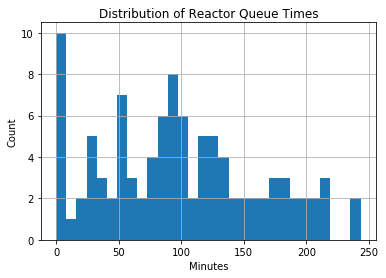

In [10]:
process_log(log)

## Encapsulating a Process as a Python Class

A SimPy process can hold a lot of parts! For that reason it is often convenient to encapsulate a process into a Python class that can handle the initialization of simulation environment, setting up a simulation log, and functions to return desired performance indicators. 

This is demonstrated here for the batch process application. An extra feature has been added where the number of reactors can be specified to allow a parametric study of the process design. 

Mean Order Completion =  531.6 min.

Mean Time in Process Stages:

     Reactor Queue =   43.4 min.
          Reactors =  338.8 min.
    Reactor Holdup =    1.4 min.
           Storage =   36.4 min.
             Still =  111.5 min.

Utilization

Reactor Utilization = 0.969
  Still Utilization = 0.950


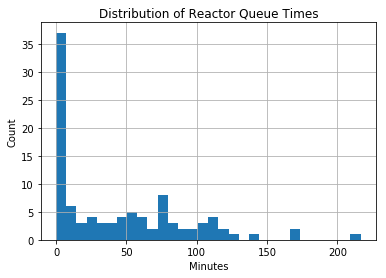

In [11]:
class batch_process(object):
    
    def __init__(self, N_ORDERS=100, N_REACTORS = 3):
        self.env = simpy.Environment()
        self.log = []
        self.reactor_queue = simpy.Store(self.env)
        self.storage_tank = simpy.Store(self.env,1)
        self.env.process(self.order_generator(N_ORDERS))
        for n in range(1,N_REACTORS+1):
            name = 'Reactor_{0:d}'.format(n)
            self.env.process(self.batch_reactor(name))
        self.env.process(self.batch_still('Still'))
        
    def writeLog(self, orderID, stage, event):
        self.log.append([orderID, stage, event, self.env.now])
        
    def order_generator(self,N_ORDERS):
        orderID = 0
        while orderID < N_ORDERS:
            yield self.env.timeout(random.uniform(115-30,115+30))
            orderID += 1
            yield self.reactor_queue.put(orderID)
            self.writeLog(orderID, 'Stage 0', 'Queue')
            
    def batch_reactor(self,name):
        while True:
            orderID = yield self.reactor_queue.get()
            self.writeLog(orderID, 'Stage 1', name)
            yield self.env.timeout(random.uniform(335-60,335+60))
            self.writeLog(orderID, 'Stage 2', name)
            yield self.storage_tank.put(orderID)
            self.writeLog(orderID, 'Stage 3', 'Storage')

    def batch_still(self,name):
        while True:
            orderID = yield self.storage_tank.get()
            self.writeLog(orderID, 'Stage 4', name)
            yield self.env.timeout(random.uniform(110-25,110+25))
            self.writeLog(orderID, 'Stage 5', 'complete')
            
    def process_log(self):
        df = pd.DataFrame([[a,b,c,t] for (a,b,c,t) in self.log])
        df = df.pivot(index=0,columns=1,values=3).reset_index()
        df = df.set_index([0]).dropna()
        df.index.rename('OrderID',inplace=True)

        stage1 = df['Stage 1']-df['Stage 0']
        stage2 = df['Stage 2']-df['Stage 1']
        stage3 = df['Stage 3']-df['Stage 2']
        stage4 = df['Stage 4']-df['Stage 3']
        stage5 = df['Stage 5']-df['Stage 4']

        print('Mean Order Completion = {0:6.1f} min.\n'.format((df['Stage 5'] - df['Stage 0']).mean()))

        print('Mean Time in Process Stages:\n')
        print('     Reactor Queue = {0:6.1f} min.'.format(stage1.mean()))
        print('          Reactors = {0:6.1f} min.'.format(stage2.mean()))
        print('    Reactor Holdup = {0:6.1f} min.'.format(stage3.mean()))
        print('           Storage = {0:6.1f} min.'.format(stage4.mean()))
        print('             Still = {0:6.1f} min.'.format(stage5.mean()))

        print('\nUtilization\n')
        print('Reactor Utilization = {0:5.3f}'.format(stage2.sum()/3.0/(df['Stage 2'].max()-df['Stage 2'].min())))
        print('  Still Utilization = {0:5.3f}'.format(stage5.sum()/(df['Stage 5'].max()-df['Stage 5'].min())))
    
        stage1.hist(bins=30)
        plt.title('Distribution of Reactor Queue Times')
        plt.ylabel('Count')
        plt.xlabel('Minutes')        
            
    def run(self):
        self.env.run()
                  
            
b = batch_process(N_REACTORS=3)         
b.run()
b.process_log()
        


## References

Engell, Sebastian. "Introduction to the Special Issue on Discrete Event Models of Continuous Systems." Mathematical and Computer Modeling of Dynamical Systems, Vol. 6, No. 1, pp 3-5 (2010).

Schultheisz, Daniel, and Jude T. Sommerfeld. "Discrete-Event Simulation in Chemical Engineering." Chemical Engineering Education 22.2 (1988): 98-102.
